In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import umap
import datashader as ds
import colorcet as cc
import igraph
import tqdm
from scipy import sparse
from scipy import stats
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import KMeans
from scipy.spatial import Delaunay
import json
import itertools
import time

from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap

from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils.__init__plots import * 
from dredFISH.Utils import powerplots
from dredFISH.Utils import miscu
from dredFISH.Utils import tmgu

import importlib
importlib.reload(Viz)
importlib.reload(TissueGraph)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

#### Load data

In [2]:
respath = '/bigstore/GeneralStorage/fangming/projects/dredfish/figures/'

In [3]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 85M
drwxrwxrwx 9 zach     wollmanlab 4.0K Jul 20 10:38 ..
lrwxrwxrwx 1 fangming wollmanlab   67 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
lrwxrwxrwx 1 fangming wollmanlab   69 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
-rw-r--r-- 1 fangming wollmanlab   32 Jul 20 10:39 README.txt
-rw-r--r-- 1 fangming wollmanlab   88 Jul 20 10:41 TMG.json
-rw-r--r-- 1 fangming wollmanlab  53M Jul 20 10:41 cell.h5ad
drwxr-xr-x 3 fangming wollmanlab 4.0K Jul 20 10:45 .
-rw-r--r-- 1 fangming wollmanlab  32M Jul 20 10:45 default_analysis.csv
drwxr-xr-x 4 fangming wollmanlab 4.0K Jul 21 11:49 figures
{"layers_graph": [], "layer_taxonomy_mapping": {}, "Taxonomies": [], "Layers": ["cell"]}

In [4]:
df = pd.read_csv(
    os.path.join(basepth, "default_analysis.csv"), index_col=0)
df

,x,y,x2,y2,hemi,b0,b1,b2,b3,b4,...,type_r0.01,type_r0.02,type_r0.05,type_r0.1,type_r0.2,type_r0.5,type_r1,type_r2,type_r5,type_r10
0,1911.666962,-1749.638192,1833.366541,-1831.521636,1,-0.603849,1.714861,0.594060,0.139496,1.509942,...,t1,t1,t1,t3,t2,t4,t3,t16,t47,t40
1,1850.678429,-1747.172043,1772.544083,-1826.392145,1,-0.530279,1.681959,1.301185,-0.464006,1.570054,...,t1,t1,t1,t3,t2,t4,t3,t16,t47,t40
2,1515.123295,-1746.940031,1437.319766,-1811.493848,1,-0.603849,-0.362498,0.620053,-1.128423,1.206578,...,t1,t1,t1,t3,t2,t10,t9,t20,t24,t66
3,1426.161788,-1748.456394,1348.376999,-1809.120415,1,-0.298989,1.023065,1.517082,-0.341796,0.475449,...,t1,t1,t1,t3,t2,t10,t9,t20,t51,t121
4,1739.792930,-1749.407386,1661.666850,-1823.778747,1,-0.603849,-1.351786,1.025515,-1.128423,0.327118,...,t1,t1,t1,t1,t1,t1,t2,t3,t34,t21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77841,-2188.756848,-1084.480934,-2234.065840,-987.777939,0,-0.603849,-0.271399,-0.666686,0.269214,0.821624,...,t1,t1,t1,t3,t2,t8,t18,t36,t56,t57
77842,-2257.822983,-1083.270665,-2303.013073,-983.550072,0,0.936062,0.386319,-0.614982,1.752306,0.067531,...,t1,t1,t3,t4,t6,t8,t10,t6,t1,t73
77843,-2475.320577,-1083.995803,-2520.334508,-974.768090,0,-0.603849,-0.228163,-0.612215,0.895132,0.247026,...,t1,t1,t2,t2,t5,t6,t7,t25,t41,t82
77844,-2311.578984,-1086.717336,-2356.868349,-984.643871,0,-0.603849,-1.153599,0.699586,-0.204732,1.546018,...,t1,t1,t1,t1,t1,t1,t1,t5,t12,t26


In [5]:
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )

/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5/cell.h5ad


In [6]:
# spatial coordinates
layer = TMG.Layers[0]
XY = layer.XY
x, y = XY[:,0], XY[:,1]
###
x, y = y, x # a temporary hack
###

cells = layer.adata.obs.index.values

N = layer.N
# measured basis
ftrs_mat = layer.feature_mat

# umap_mat = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(ftrs_mat)



# Cell-cell interaction
- line (counts; distance)
- triangle (counts; distance)
- local envv (clustering)

In [7]:
def count_triplet_old(triplets, types):
    """
    """
    ti = time.time()
    unq_types, types_idx = np.unique(types, return_inverse=True)
    print(time.time()-ti)
    unq_tri, tri_counts = np.unique(np.sort(types_idx[dd.simplices]), return_counts=True, axis=0)
    print(time.time()-ti)
    
    # a = np.sort(types[triplets]).astype(str)
    # print(time.time()-ti)
    # triplet_types = np.char.add(np.char.add(a[:,0], a[:,1]), a[:,2]) #, a[:,2])
    # print(time.time()-ti)
    # uniq_types, counts = np.unique(triplet_types, return_counts=True)
    # print(time.time()-ti)
    return unq_tri, tri_counts

    
def test_triplet_enrichment_old(triplets, node_types, 
                         n_repeat=100, 
                         random_state=0):
    """
    """
    # ti = time.time()
    # house keeping
    triplets = np.asarray(triplets)
    assert triplets.shape[1] == 3
    types = node_types
    np.random.seed(random_state)
    
    # basic stats
    unq_types = np.unique(types)
    n_t = len(unq_types)
    n = len(types)
    unq_types_idx = np.arange(n_t)
    
    # all possible counts
    # a = np.array(list(itertools.combinations_with_replacement(unq_types, 3))).astype(str)
    # att = np.char.add(np.char.add(a[:,0], a[:,1]), a[:,2]) # all triplet types
    tri_codes = np.asarray(list(itertools.combinations_with_replacement(np.arange(n_t), r=3)))
    num_codes = tri_codes[:,0]*n_t*n_t + tri_codes[:,1]*n_t + tri_codes[:,2]
    
    # counts and shuffled conuts
    att_counts = pd.DataFrame(index=att, columns=np.arange(n_repeat+1))
    # print(time.time()-ti)
    # countmats = np.zeros((len(att),n_repeat+1))
    # tri_map = {tuple(i): count for count, i in enumerate(att)}

    # observed counts
    _types, _counts = count_triplet(triplets, types)
    a = unq_types[_types].astype(str)
    _types = np.char.add(np.char.add(a[:,0], a[:,1]), a[:,2]) # all triplet types
    
    # print(time.time()-ti)
    att_counts.loc[_types, 0] = _counts
    # print(time.time()-ti)
    # shuffled counts
    for i in range(1, n_repeat+1):
        # print(time.time()-ti)
        _types, _counts = count_triplet(triplets,
                                        types[np.random.choice(n, size=n, replace=False)], # shuffle
                                        )
        a = unq_types[_types].astype(str)
        _types = np.char.add(np.char.add(a[:,0], a[:,1]), a[:,2]) # all triplet types
        # print(time.time()-ti)
        att_counts.loc[_types, i] = _counts
        # print(time.time()-ti)
        break
    
    # org
    countmats = att_counts.fillna(0).astype(int).values
    
    # count ~ [1, n_rep+1]; percentiles ~ [0,1]
    prctls = (stats.rankdata(countmats, axis=1)[:,0]-1)/n_repeat
    pvals = 2*np.clip(np.minimum(prctls, 1-prctls), 1/n_repeat, None)
    rej, qvals, _, _ = multipletests(pvals, # indep tests
                                     method='fdr_bh')
    
    obs = countmats[:,0]
    exp = np.mean(countmats[:,1:], axis=1)
    enr = (obs+1)/(exp+1)
    return att, pvals, qvals, enr, obs, exp, countmats
        

In [8]:
def count_triplet(triplets, types_idx):
    """
    """
    # ti = time.time()
    unq_tri, tri_counts = np.unique(np.sort(types_idx[dd.simplices]), return_counts=True, axis=0)
    # print(time.time()-ti)
    return unq_tri, tri_counts
    
def test_triplet_enrichment(triplets, node_types, 
                         n_repeat=100, 
                         random_state=0):
    """
    """
    ti = time.time()
    # house keeping
    np.random.seed(random_state)
    
    triplets = np.asarray(triplets)
    assert triplets.shape[1] == 3
    
    types = node_types
    n = len(types)
    unq_types, types_idx = np.unique(types, return_inverse=True)
    n_t = len(unq_types)
    unq_types_idx = np.arange(n_t)
    
    # all possible counts
    tri_codes = np.asarray(list(itertools.combinations_with_replacement(np.arange(n_t), r=3)))
    num_codes = tri_codes[:,0]*n_t*n_t + tri_codes[:,1]*n_t + tri_codes[:,2]
    
    # counts and shuffled conuts
    att_counts = pd.DataFrame(index=num_codes, columns=np.arange(n_repeat+1))
    # countmats = np.zeros((len(att),n_repeat+1))
    # print(time.time()-ti)

    # observed counts
    _types, _counts = count_triplet(triplets, types_idx)
    _types = _types[:,0]*n_t*n_t + _types[:,1]*n_t + _types[:,2]
    # print(time.time()-ti)
    att_counts.loc[_types, 0] = _counts
    
    # shuffled counts
    for i in range(1, n_repeat+1):
        _types, _counts = count_triplet(triplets,
                                        types_idx[np.random.choice(n, size=n, replace=False)], # shuffle
                                        )
        # print(time.time()-ti)
        _types = _types[:,0]*n_t*n_t + _types[:,1]*n_t + _types[:,2]
        att_counts.loc[_types, i] = _counts
        # break
    
    # org
    countmats = att_counts.fillna(0).astype(int).values
    
    # count ~ [1, n_rep+1]; percentiles ~ [0,1]
    prctls = (stats.rankdata(countmats, axis=1)[:,0]-1)/n_repeat
    pvals = 2*np.clip(np.minimum(prctls, 1-prctls), 1/n_repeat, None)
    rej, qvals, _, _ = multipletests(pvals, # indep tests
                                     method='fdr_bh')
    
    obs = countmats[:,0]
    exp = np.mean(countmats[:,1:], axis=1)
    enr = (obs+1)/(exp+1)
    return unq_types, tri_codes, pvals, qvals, enr, obs, exp, countmats
        

In [9]:
N = len(XY)

# from meta
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(f, 'r') as fh:
    meta = json.load(fh)
    
dd = Delaunay(XY)
dd.simplices

array([[77504, 77461, 77434],
       [77475, 77495, 77484],
       [62277, 62379, 62215],
       ...,
       [36209, 36222, 36210],
       [36253, 36222, 36251],
       [36222, 36237, 36251]], dtype=int32)

In [10]:
%%time
triplets = dd.simplices 
typecol = 'type_r0.1'
types = df[typecol].values

(unq_types, tri_codes, pvals, qvals, enr, obs, exp, countmats) = test_triplet_enrichment(
    triplets, types, n_repeat=1000, random_state=0)



CPU times: user 3min 1s, sys: 132 ms, total: 3min 1s
Wall time: 3min 1s


In [11]:
alpha = 0.01

res = pd.DataFrame()
res['log2(enr)'] = np.log2(enr)
res['q'] = qvals
res['tri'] = [", ".join(tri_type) for tri_type in unq_types[tri_codes]]
res['sig'] = res['q'] < alpha
res = res.sort_values('log2(enr)', ascending=False)
res.head()

,log2(enr),q,tri,sig
34,9.282770,0.002,"t5, t5, t5",True
31,5.350711,0.002,"t4, t4, t4",True
14,2.937092,0.002,"t1, t5, t5",True
25,2.790080,0.002,"t3, t3, t3",True
15,2.690239,0.002,"t2, t2, t2",True


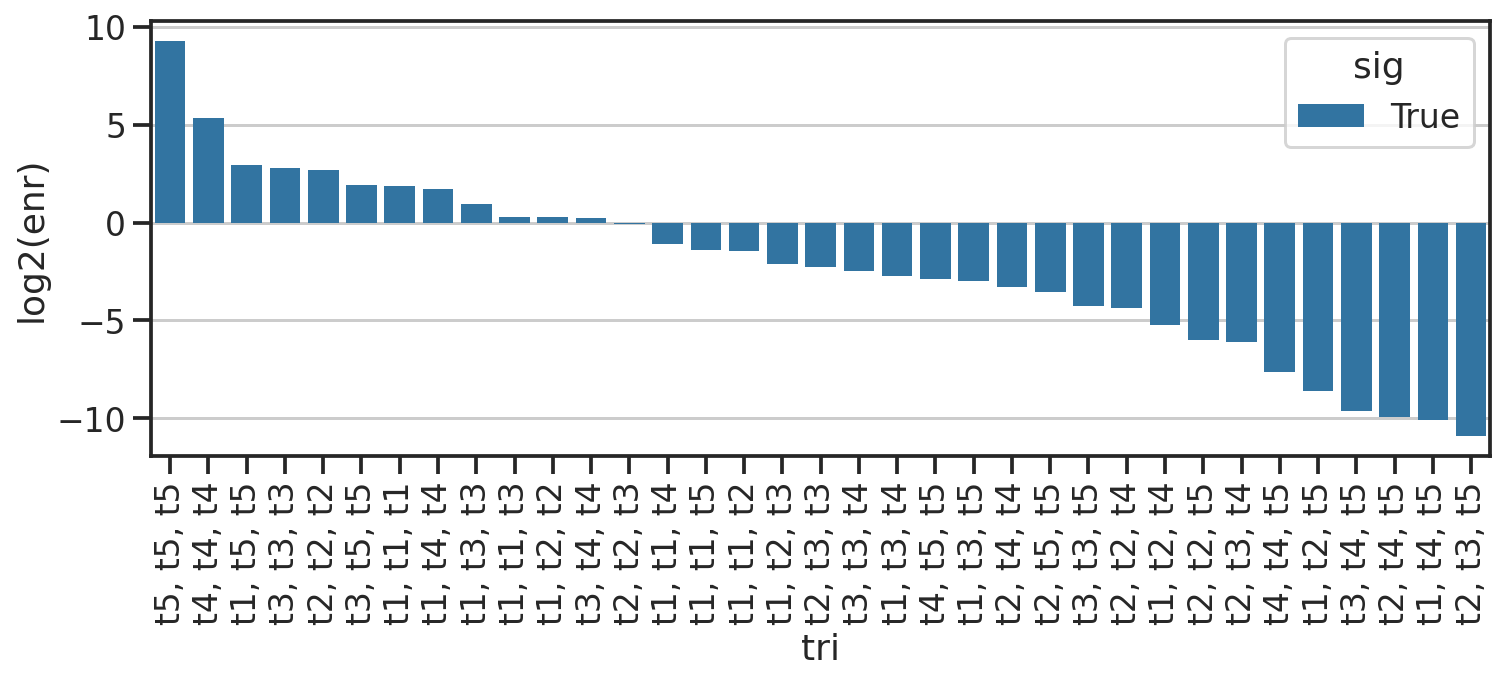

In [12]:
# 
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=res, x='tri', y='log2(enr)', hue='sig', 
            edgecolor='none',
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

# second case

In [13]:
%%time
triplets = dd.simplices 
typecol = 'ktype_L3'
types = df[typecol].values

(unq_types, tri_codes, pvals, qvals, enr, obs, exp, countmats) = test_triplet_enrichment(
    triplets, types, n_repeat=1000, random_state=0)



CPU times: user 2min 57s, sys: 1.27 s, total: 2min 59s
Wall time: 2min 59s


In [14]:
alpha = 0.01

res = pd.DataFrame()
res['log2(enr)'] = np.log2(enr)
res['q'] = qvals
res['tri'] = [", ".join(tri_type) for tri_type in unq_types[tri_codes]]
res['diff-tri'] = tri_codes[:,2] > tri_codes[:,0]
res['ndiff'] = (1+(tri_codes[:,1] > tri_codes[:,0]) + (tri_codes[:,2] > tri_codes[:,1])).astype(str) # categorical

res['sig'] = res['q'] < alpha
res = res.sort_values('log2(enr)', ascending=False)
print(res.shape)
res.head(10)

(13244, 6)


,log2(enr),q,tri,diff-tri,ndiff,sig
2584,9.408997,0.005709,"CA3, CA3, CA3",False,1,True
903,8.129829,0.005709,"CA1-ProS, CA1-ProS, CA1-ProS",False,1,True
13240,7.487244,0.005709,"VLMC, VLMC, VLMC",False,1,True
10319,7.341729,0.005709,"L4/5 IT CTX, L4/5 IT CTX, L4/5 IT CTX",False,1,True
5474,7.184999,0.005709,"DG, DG, DG",False,1,True
11914,6.954849,0.005709,"L6 CT CTX, L6 CT CTX, L6 CT CTX",False,1,True
12428,6.475895,0.005709,"L6b CTX, L6b CTX, L6b CTX",False,1,True
1804,6.459089,0.005709,"CA2-IG-FC, CA3, CA3",True,2,True
7788,6.430195,0.005709,"L2/3 IT CTX, L2/3 IT CTX, L2/3 IT CTX",False,1,True
12564,6.410892,0.005709,"L6b/CT ENT, L6b/CT ENT, L6b/CT ENT",False,1,True


In [15]:
# check how many sig cases
print(f"Num. possible triplets: {len(res)}")
print(f"Num. significant (FDR<0.01) triplets: {res['sig'].sum()}")
print(f"Num. significant (FDR<0.01) triplets with >2 FC: {np.logical_and(res['sig'], np.abs(res['log2(enr)']) > 1).sum()}")

Num. possible triplets: 13244
Num. significant (FDR<0.01) triplets: 4819
Num. significant (FDR<0.01) triplets with >2 FC: 4699


In [16]:
cond = (np.logical_and(res['sig'], np.abs(res['log2(enr)']) > 1))
res_sgst = res[cond].sort_values('log2(enr)')
res_sgst

,log2(enr),q,tri,diff-tri,ndiff,sig
1580,-6.137401,0.005709,"CA1-ProS, L6 CT CTX, Meis2",True,3,True
5766,-6.085488,0.005709,"DG, L4 RSP-ACA, Meis2",True,3,True
1430,-5.995371,0.005709,"CA1-ProS, L4 RSP-ACA, Oligo",True,3,True
1475,-5.922079,0.005709,"CA1-ProS, L5 IT CTX, Meis2",True,3,True
1451,-5.910301,0.005709,"CA1-ProS, L4/5 IT CTX, Meis2",True,3,True
...,...,...,...,...,...,...
5474,7.184999,0.005709,"DG, DG, DG",False,1,True
10319,7.341729,0.005709,"L4/5 IT CTX, L4/5 IT CTX, L4/5 IT CTX",False,1,True
13240,7.487244,0.005709,"VLMC, VLMC, VLMC",False,1,True
903,8.129829,0.005709,"CA1-ProS, CA1-ProS, CA1-ProS",False,1,True


In [17]:
colors = sns.color_palette('Set2', 3)
palette = {str(i+1): color for i, color in enumerate(colors)}
palette

{'1': (0.4, 0.7607843137254902, 0.6470588235294118),
 '2': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 '3': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}

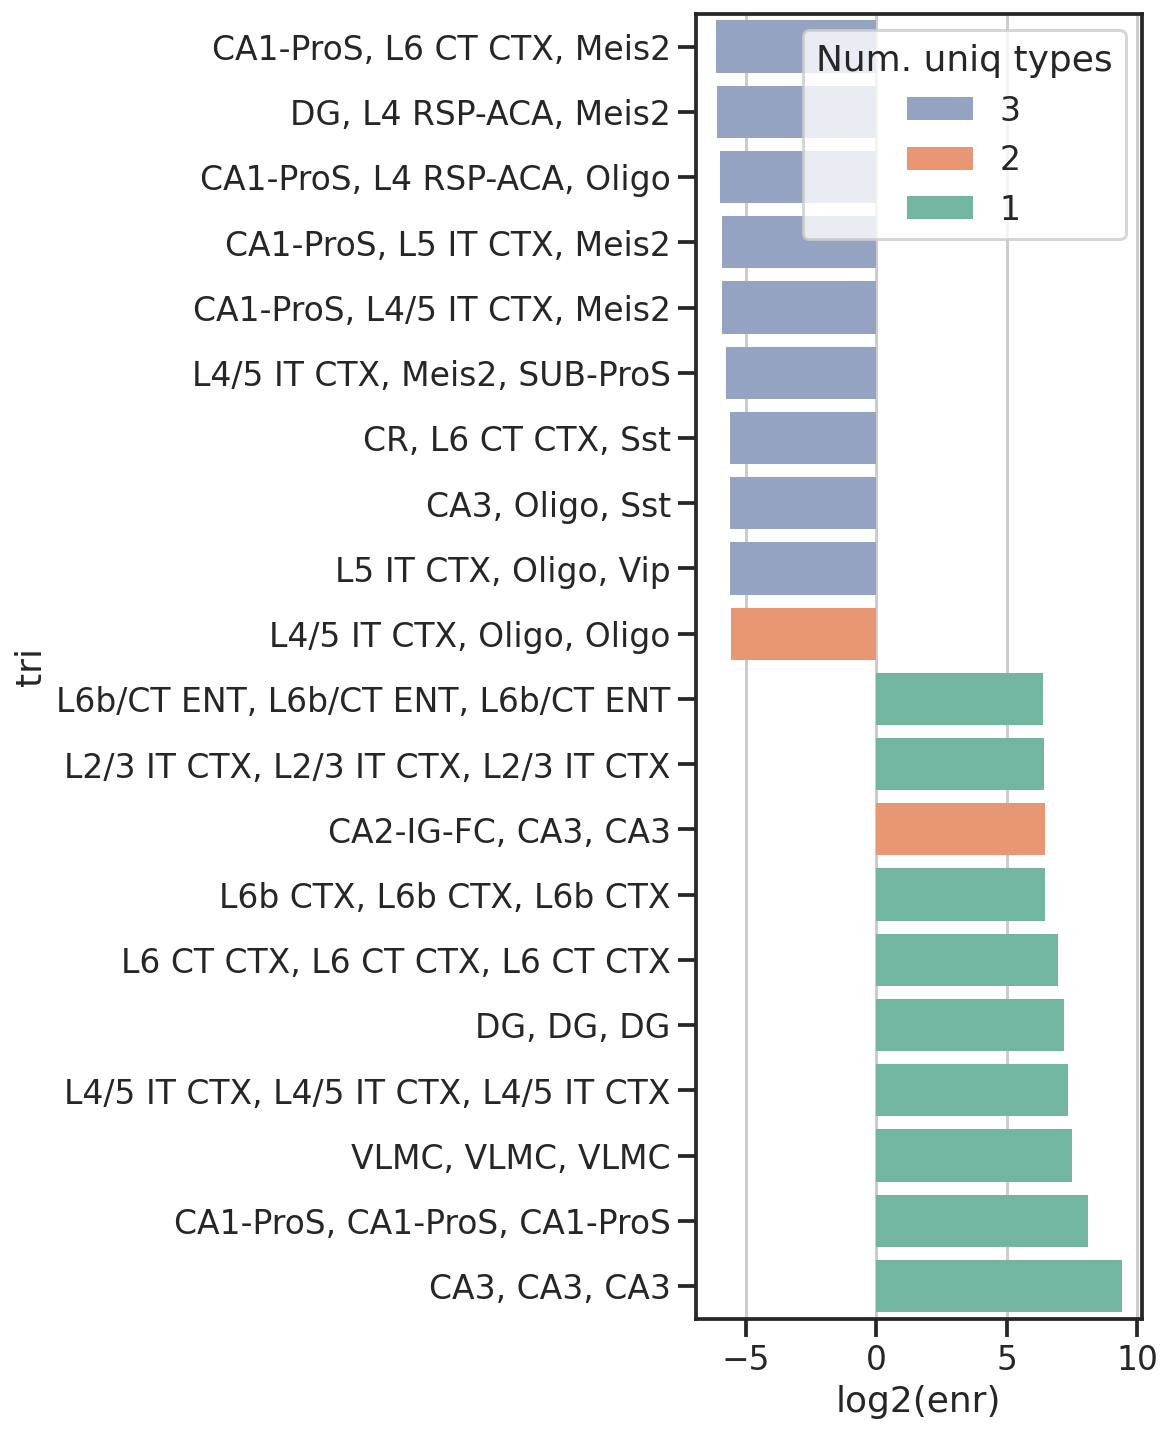

In [18]:
# 
toplot = res_sgst.iloc[np.hstack([
    np.arange(10), 
    np.arange(-10, 0),
])]

fig, ax = plt.subplots(figsize=(4,12))
sns.barplot(data=toplot,
            y='tri', x='log2(enr)', hue='ndiff', dodge=False,
            edgecolor='none',
            palette=palette,
            ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.legend(title='Num. uniq types')
plt.show()

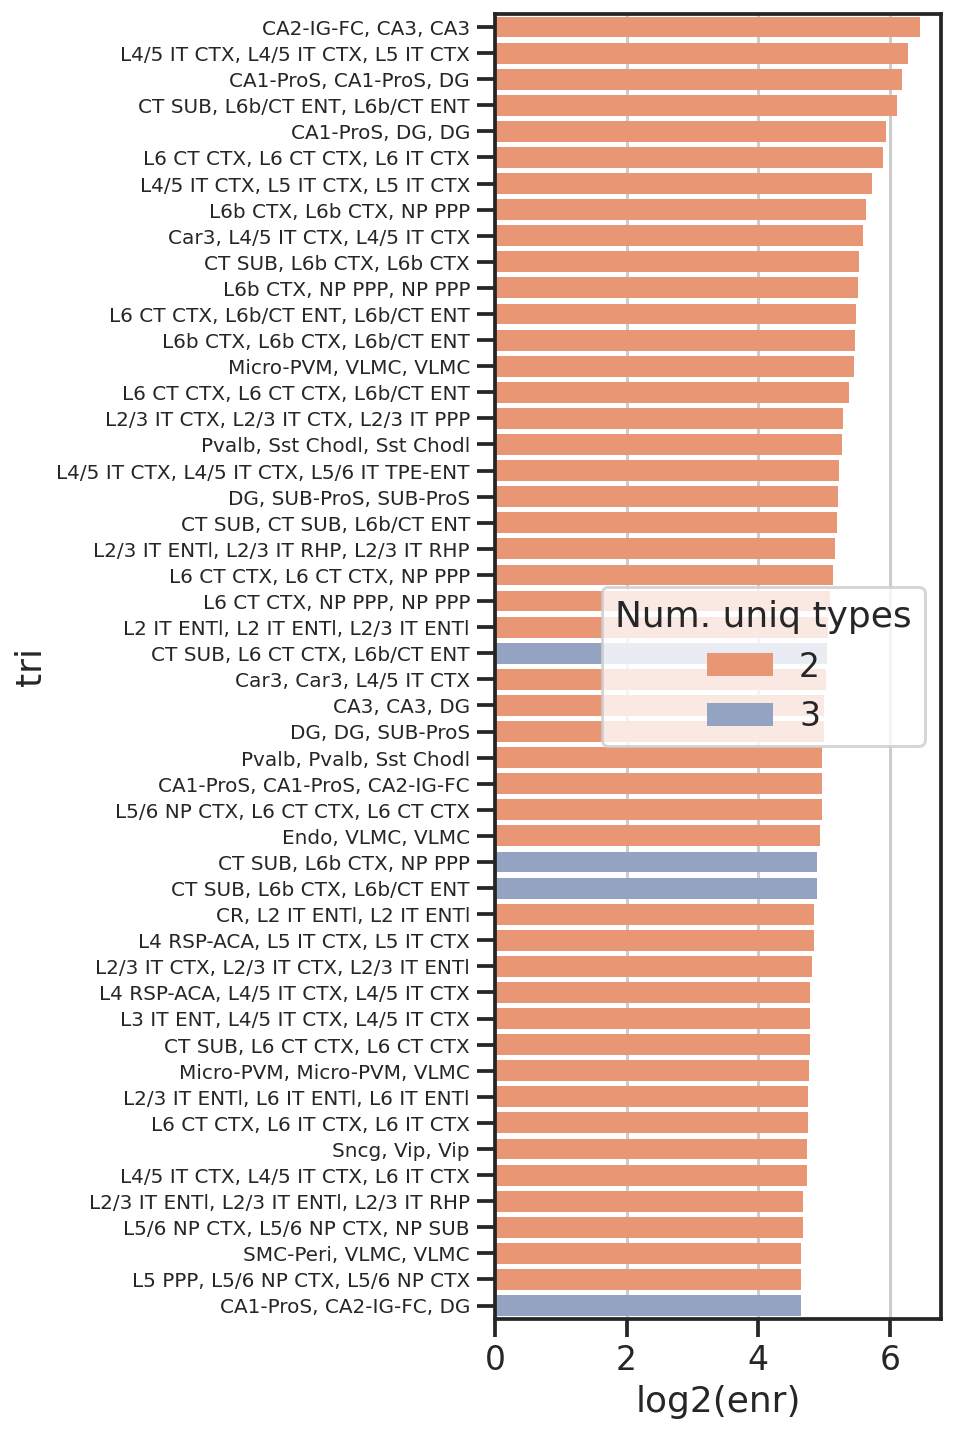

In [19]:
# top non-self cases
toplot = res_sgst[res_sgst['diff-tri']].iloc[-50:].iloc[::-1]

fig, ax = plt.subplots(figsize=(4,12))
sns.barplot(data=toplot,
            y='tri', x='log2(enr)', hue='ndiff', dodge=False,
            edgecolor='none',
            palette=palette,
            ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.legend(title='Num. uniq types')
plt.show()